In [ ]:
import os
import torch
import clip
import numpy as np
from PIL import Image
import umap
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

/Users/kristianfriisnielsen/anaconda3/envs/MAIN/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


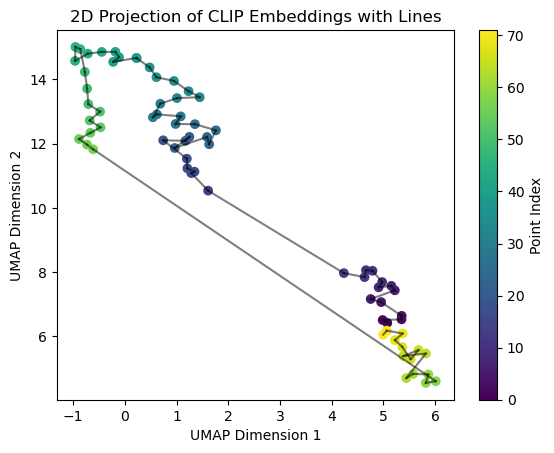

X Coordinates: [ 5.074127    4.985327    5.3495755   5.353402    4.955769    4.7541704
  5.2203507   5.1530466   4.907571    4.9749002   4.788569    4.6630096
  4.635125    4.2352896   1.6108276   1.2858282   1.3476617   1.2096709
  1.1998024   0.74191344  1.1724843   1.249166    0.9653013   1.589818
  1.6314523   1.7620118   1.3552059   0.9814317   1.080633    0.6209035
  0.54326755  0.6866892   1.0087042   1.44893     1.2327657   0.95096546
  0.6118927   0.4812154   0.22757266  0.22662638 -0.22486551 -0.1111244
 -0.18154085 -0.44558835 -0.71511126 -0.9613657  -0.9539527  -0.8599304
 -0.7723874  -0.72780627 -0.70546424 -0.47761822 -0.6796439  -0.4701619
 -0.66521466 -0.8845881  -0.7302771  -0.6121467   6.0122848   5.8194776
  5.867573    5.576092    5.4431853   5.8200517   5.3835196   5.679341
  5.5270023   5.3666472   5.2227488   5.371879    5.063942    4.994646  ]
Y Coordinates: [ 6.4209642  6.510576   6.533465   6.6405663  7.068795   7.165594
  7.4360867  7.5740185  7.530479   7.69

In [152]:
def load_and_embed_images(image_paths, device):
    # Load the CLIP model
    model, preprocess = clip.load("ViT-B/32", device)
    
    embeddings = []
    
    for image_path in image_paths:
        # Open and preprocess the image
        image = Image.open(image_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        # Get the image embeddings using CLIP
        with torch.no_grad():
            image_features = model.encode_image(image_input)
        
        # Normalize the features and append them to the embeddings list
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features.cpu().numpy())
    
    # Convert embeddings list to numpy array
    return np.vstack(embeddings)

# Function to perform UMAP projection on the embeddings
def project_embeddings_2d(embeddings, random_seed):
    reducer = umap.UMAP(random_state=random_seed)
    umap_embeddings = reducer.fit_transform(embeddings)
    
    return umap_embeddings  # Return the UMAP coordinates

# Function to visualize the 2D projection, draw lines between successive points, and add a colorbar
def visualize_2d_projection(umap_embeddings):
    # Generate a colormap based on the index of each point (0 to 71)
    cmap = plt.get_cmap("viridis")
    norm = Normalize(vmin=0, vmax=len(umap_embeddings)-1)
    
    # Plot points with color based on their index
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=np.arange(len(umap_embeddings)), cmap=cmap, norm=norm)
    
    # Draw lines between successive points
    for i in range(1, len(umap_embeddings)):
        plt.plot([umap_embeddings[i-1, 0], umap_embeddings[i, 0]], 
                 [umap_embeddings[i-1, 1], umap_embeddings[i, 1]], 'k-', alpha=0.5)
    
    plt.title("2D Projection of CLIP Embeddings with Lines")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    
    # Add colorbar to the plot
    cbar = plt.colorbar(scatter)
    cbar.set_label("Point Index")
    
    plt.show()

# Main script
def main():
    # Path to the images
    image_folder = "coil-100/"
    image_paths = [os.path.join(image_folder, f"obj99__{i}.png") for i in range(0, 360, 5)]  # Adjusted for 5 degree steps
    
    # Check if CUDA is available for using GPU, otherwise fallback to CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load and embed images using CLIP
    embeddings = load_and_embed_images(image_paths, device)
    
    # Project embeddings to 2D using UMAP
    umap_embeddings = project_embeddings_2d(embeddings, random_seed = 42)
    
    # Visualize the 2D projection with colorbar and lines between points
    visualize_2d_projection(umap_embeddings)
    
    # Return the x and y coordinates for further use
    return umap_embeddings[:, 0], umap_embeddings[:, 1]  # x and y coordinates

# Run the script and get the x and y coordinates
if __name__ == "__main__":
    x_coords, y_coords = main()
    print("X Coordinates:", x_coords)
    print("Y Coordinates:", y_coords)


In [ ]:
import numpy as np

def calculate_angles(x_coords, y_coords):

    points = np.column_stack((x_coords, y_coords))
    num_points = len(points)
    padded_points = np.vstack((points[-1], points, points[0]))

    angles = []
    lengths = []

    for i in range(1, num_points + 1):  # Loop over original points (ignoring padding)
        prev_point = padded_points[i - 1]
        curr_point = padded_points[i]
        next_point = padded_points[i + 1]

        # Vectors from current to prev/next
        vec_prev = prev_point - curr_point
        vec_next = next_point - curr_point

        # Compute norms (magnitudes)
        norm_prev = np.linalg.norm(vec_prev)
        norm_next = np.linalg.norm(vec_next)

        lengths.append(norm_prev)

        # Check for zero-length vectors (threshold for floating-point precision)
        if norm_prev < 1e-8 or norm_next < 1e-8:
            print(f"Warning: Zero-length vector at point {i-1} (coords: {curr_point})")
            angles.append(np.nan)
            continue

        # Compute cosine of the angle
        cos_theta = np.dot(vec_prev, vec_next) / (norm_prev * norm_next)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)  # Ensure valid arccos input

        # Get angle in degrees
        angle_deg = np.degrees(np.arccos(cos_theta))

        # Smallest angle (0° to 180°)
        smallest_angle = min(angle_deg, 360 - angle_deg)
        angles.append(smallest_angle)

    return angles, lengths

angles, lengths = calculate_angles(x_coords, y_coords)

def CV(input):
    cvar = np.std(input) / np.mean(input)
    return cvar

print(CV(lengths))
print(CV(angles))

2.309106
0.4810525912725035


In [ ]:
#12: smooth with slight breakdown
#59: extreme breakdown, relatively smooth 

(73,)


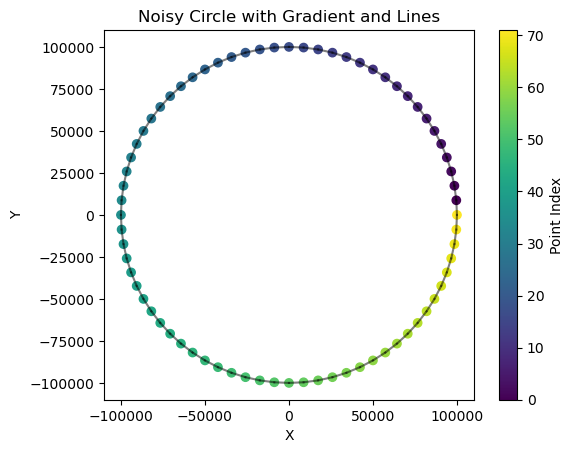

In [150]:
num_points = 73  # number of points on the circle
radius = 100000 # radius of the circle
noise_level = 0

# Generate x and y coordinates using parametric equations for a circle
theta = np.linspace(0, 2 * np.pi, num_points)
noise = np.random.normal(0, noise_level, num_points)
print(noise.shape)
x_coords = (noise + radius) * np.cos(theta) 
y_coords = (noise + radius) * np.sin(theta) 
x_coords = x_coords[1:]
y_coords = y_coords[1:]


cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=len(x_coords)-1)

# Plot points with color based on their index
scatter = plt.scatter(x_coords, y_coords, c=np.arange(len(x_coords)), cmap=cmap, norm=norm)

# Draw lines between successive points
for i in range(1, len(x_coords)):
    plt.plot([x_coords[i-1], x_coords[i]], [y_coords[i-1], y_coords[i]], 'k-', alpha=0.5)

# To close the circle, draw a line from the last point to the first
plt.plot([x_coords[-1], x_coords[0]], [y_coords[-1], y_coords[0]], 'k-', alpha=0.5)

# Add a colorbar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label("Point Index")

plt.title("Noisy Circle with Gradient and Lines")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().set_aspect('equal', adjustable='box')  # Ensure equal scaling of axes
plt.show()